# Fine Tuning

When we employ the technique defined above, we will often want to tweak the final layers in our convolutional base to work better for our specific problem. This involves not touching or retraining the earlier layers in our convolutional base but only adjusting the final few. We do this because the first layers in our base are very good at extracting low level features lile lines and edges, things that are similar for any kind of image. Where the later layers are better at picking up very specific features like shapes or even eyes. If we adjust the final layers than we can look for only features relevant to our very specific problem.

## Using a Pretrained Model
In this section we will combine the tecniques we learned above and use a pretrained model and fine tuning to classify images of dogs and cats using a small dataset.

*This tutorial is based on the following guide from the TensorFlow documentation: https://www.tensorflow.org/tutorials/images/transfer_learning*

In [ ]:
# Step 1: Initialiing

# %tensorflow_version 2.x  # this line is not required unless you are in a notebook

from dotenv import load_dotenv

load_dotenv()

import os
from typing import Any, Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

keras = tf.keras

### Dataset

We will load the *cats_vs_dogs* dataset from the modoule tensorflow_datatsets.

This dataset contains (image, label) pairs where images have different dimensions and 3 color channels.

### Data Preprocessing

Since the sizes of our images are all different, we need to convert them all to the same size. We can create a function that will do that for us below.

In [12]:
# Step 2: Load dataset using tf.keras.utils instead of tensorflow_datasets

# Original tensorflow-datasets code (commented due to protobuf compatibility issues):
# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()
# (raw_train, raw_validation, raw_test), metadata = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
#     with_info=True,
#     as_supervised=True,
# )
# get_label_name = metadata.features['label'].int2str
# for image, label in raw_train.take(5):
#   plt.figure()
#   plt.imshow(image)
#   plt.title(get_label_name(label))

print("Started data load...")

# Download and prepare the cats vs dogs dataset (using direct link instead of `tfds.load('cats_vs_dogs', ...)
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
print("Data is already loaded")
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=url, extract=True)
print("File is ready")
base_dir = os.path.dirname(path_to_zip)

# Check what directories exist
print(f"Base directory: {base_dir}")
print(f"Contents: {os.listdir(base_dir)}")

# The actual path is in the extracted directory
PATH = os.path.join(base_dir, "cats_and_dogs_extracted", "PetImages")
if not os.path.exists(PATH):
    # Try alternative paths
    extracted_dir = os.path.join(base_dir, "cats_and_dogs_extracted")
    if os.path.exists(extracted_dir):
        print(f"Extracted dir contents: {os.listdir(extracted_dir)}")
        for item in os.listdir(extracted_dir):
            item_path = os.path.join(extracted_dir, item)
            if os.path.isdir(item_path):
                try:
                    contents = os.listdir(item_path)
                    if "Cat" in contents and "Dog" in contents:
                        PATH = item_path
                        break
                except:
                    continue

# Check if the data path has been correctly located
print(f"Using PATH: {PATH}")
if os.path.exists(PATH):
    print(f"PATH contents: {os.listdir(PATH)}")
else:
    print("PATH does not exist")
    exit(1)

# Clean up corrupted images first (a long operation)
import glob

print("Cleaning corrupted images...")
for folder in ["Cat", "Dog"]:
    folder_path = os.path.join(PATH, folder)
    files_removed = 0
    for file_path in glob.glob(os.path.join(folder_path, "*")):
        try:
            img = tf.io.read_file(file_path)
            tf.image.decode_image(img)
        except:
            print(f"Removing corrupted file: {os.path.basename(file_path)}")
            os.remove(file_path)
            files_removed += 1
    print(f"Removed {files_removed} corrupted files from {folder}")

# Create datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Create training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    # @see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
    PATH,
    validation_split=0.2,  # Optional float between 0 and 1, fraction of data to reserve for validation.
    subset="training",  # Subset of the data to return. One of "training", "validation", or "both". Only used if validation_split is set. When subset="both", the utility returns a tuple of two datasets (the training and validation datasets respectively).
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,  # Size of the batches of data. Defaults to 32. If None, the data will not be batched (the dataset will yield individual samples).
)

# Create validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    # @see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
    PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# # Create validation dataset
# test_dataset = tf.keras.utils.image_dataset_from_directory(
#     # @see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
#     PATH,
#     validation_split=0.2,
#     subset="test",
#     seed=123,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
# )

class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Started data load...
Data is already loaded
File is ready
Base directory: C:\Users\User\.keras\datasets
Contents: ['cats_and_dogs.zip', 'cats_and_dogs_extracted', 'cifar-10-batches-py-target', 'cifar-10-batches-py-target_archive', 'fashion-mnist', 'iris_test.csv', 'iris_training.csv']
Using PATH: C:\Users\User\.keras\datasets\cats_and_dogs_extracted\PetImages
PATH contents: ['Cat', 'Dog']
Cleaning corrupted images...
Removing corrupted file: 10404.jpg
Removing corrupted file: 4351.jpg
Removing corrupted file: 666.jpg
Removing corrupted file: Thumbs.db
Removed 4 corrupted files from Cat
Removing corrupted file: 11233.jpg
Removing corrupted file: 11702.jpg
Removing corrupted file: 11912.jpg
Removing corrupted file: 2317.jpg
Removing corrupted file: 2494.jpg
Removing corrupted file: 9500.jpg
Removing corrupted file: Thumbs.db
Removed 7 corrupted files from Dog
Found 24991 files belonging to 2 classes.
Using 19993 files for training.
Found 24991 files belonging to 2 classes.
Using 4998 fil

Let's have a look at our images now.

Show 2 of 32 images for the batch #0...
Batch #0, image #0: Cat


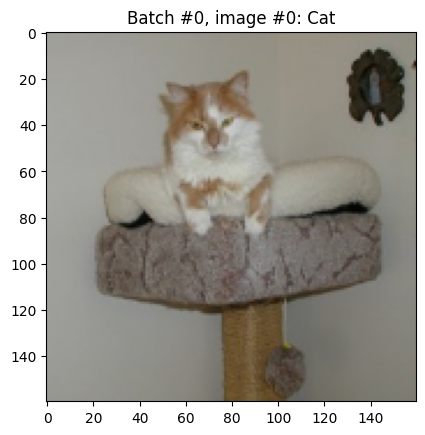

Batch #0, image #1: Cat


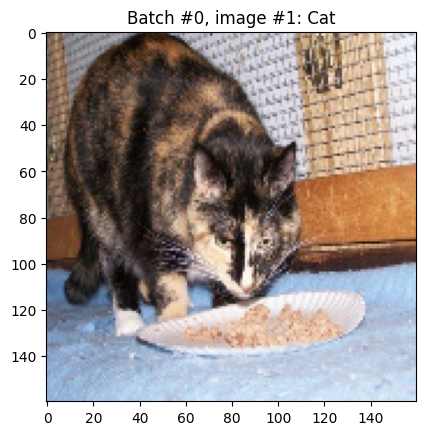

Finished displaying of the batch #0
Show 2 of 32 images for the batch #1...
Batch #1, image #0: Cat


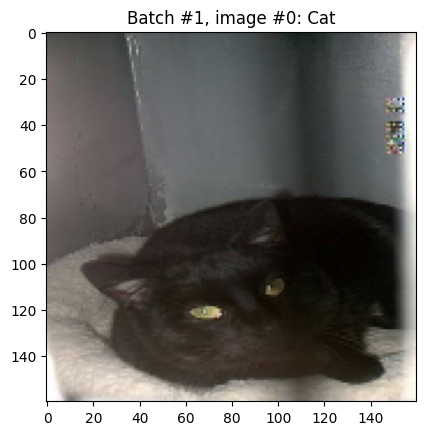

Batch #1, image #1: Cat


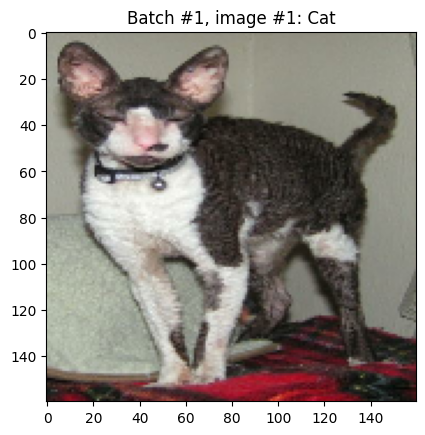

Finished displaying of the batch #1
Show 2 of 32 images for the batch #2...
Batch #2, image #0: Dog


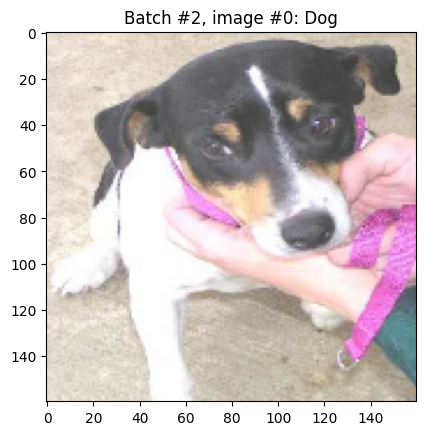

Batch #2, image #1: Dog


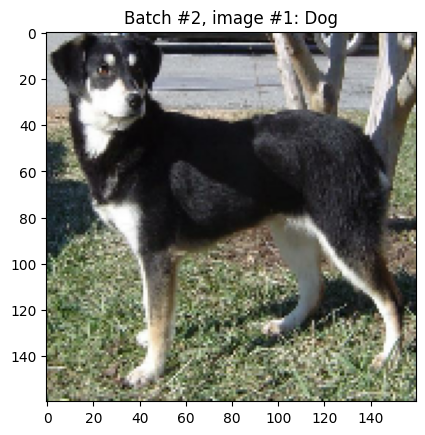

Finished displaying of the batch #2
Done


In [31]:
# Step 3: Show some of the loaded images

# Simple label function
get_label_name: Callable[[Any], str] = lambda x: class_names[x] if x < len(class_names) else f"Label {x}"

# Take a few samples for display
raw_train = train_dataset.take(3)  # Take first batch for display

# Display a few images from the dataset
for batch_no, (images, labels) in enumerate(raw_train):
    images_count = len(images)
    show_images_count = min(2, len(images))
    print(f"Show {show_images_count} of {images_count} images for the batch #{batch_no}...")
    for i in range(show_images_count):
        title = f"Batch #{batch_no}, image #{i}: {get_label_name(labels[i].numpy())}"
        print(title)
        plt.figure()
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(title)
        plt.show()
    print(f"Finished displaying of the batch #{batch_no}")
    # break  # Only show first batch

# NOTE: Set a breakpoint to show the displayed images
print("Done")

Finally we will shuffle and batch the images.

In [18]:
# Step 4: Shuffle

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# train_batches = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# validation_batches = validation_dataset.batch(BATCH_SIZE)
# test_batches = test_dataset.batch(BATCH_SIZE)
train_batches = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
validation_batches = validation_dataset

for img, label in train_dataset.take(2):
    print("New shape:", img.shape)

New shape: (32, 160, 160, 3)
New shape: (32, 160, 160, 3)


### Picking a Pretrained Model

The model we are going to use as the convolutional base for our model is the MobileNet V2 developed at Google. This model is trained on 1.4 million images and has 1000 different classes.

We want to use this model but only its convolutional base. So, when we load in the model, we'll specify that we don't want to load the top (classification) layer. We'll tell the model what input shape to expect and to use the predetermined weights from imagenet (Googles dataset).

In [32]:
# Step 5: Picking a Pretrained Model

IMG_SHAPE = IMG_SIZE + (3,)  # IMG_SIZE is already (160, 160), so this becomes (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

base_model.summary()
# Too long output
# The last line of the table is:
# │ out_relu (ReLU) │ (None, 5, 5, 1280) │ 0 │ Conv_1_bn[0][0] │

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

At this point this base_model will simply output a shape (32, 5, 5, 1280) tensor that is a feature extraction from our original (1, 160, 160, 3) image. The 32 means that we have 32 layers of differnt filters/features.

In [33]:
# Step 6: Check the model

last_image = None

for image, _ in train_batches.take(1):
    last_image = image

feature_batch = base_model(last_image)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Freezing the Base

The term freezing refers to disabling the training property of a layer. It simply means we won’t make any changes to the weights of any layers that are frozen during training. This is important as we don't want to change the convolutional base that already has learned weights.

In [34]:
# Step 7: Freezing the Base

base_model.trainable = False
base_model.summary()
# Too long output. The last line of the table is:
# │ out_relu (ReLU) │ (None, 5, 5, 1280) │ 0 │ Conv_1_bn[0][0] │

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Adding our Classifier

Now that we have our base layer setup, we can add the classifier. Instead of flattening the feature map of the base layer we will use a global average pooling layer that will average the entire 5x5 area of each 2D feature map and return to us a single 1280 element vector per filter.

Finally, we will add the predicition layer that will be a single dense neuron. We can do this because we only have two classes to predict for.

Now we will combine these layers together in a model.

In [24]:
# Step 8: Adding our Classifier

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)
model = tf.keras.Sequential([base_model, global_average_layer, prediction_layer])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Training the Model

Now we will train and compile the model. We will use a very small learning rate to ensure that the model does not have any major changes made to it.

In [ ]:
# Step 9: Training the Model

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

# Now we can train it on our images (~10min)
history = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

acc = history.history["accuracy"]
print(acc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.5059 - loss: 0.7840
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 302ms/step - accuracy: 0.5758 - loss: 0.6879 - val_accuracy: 0.6731 - val_loss: 0.5533
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 280ms/step - accuracy: 0.7130 - loss: 0.5346 - val_accuracy: 0.7313 - val_loss: 0.5007
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 281ms/step - accuracy: 0.7471 - loss: 0.4920 - val_accuracy: 0.7373 - val_loss: 0.4839


[0.625468909740448, 0.722602903842926, 0.7509128451347351]


In [28]:
# Step 10: Save the model

model.save("dogs_vs_cats.keras")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model("dogs_vs_cats.keras")

And that's it for this section on computer vision!And that's it for this section on computer vision!

## Object Detection

If you'd like to learn how you can perform object detection and recognition with tensorflow check out the guide below.

https://github.com/tensorflow/models/tree/master/research/object_detection

In [30]:
# Check the file

import os

model_path = "dogs_vs_cats.keras"
if os.path.exists(model_path):
    print(f"Model found at: {os.path.abspath(model_path)}")
    print(f"File size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
else:
    print("Model file not found in current directory")

Model found at: .../src/dogs_vs_cats.keras
File size: 9.18 MB


This is an archive of the following files:

- config.json
- metadata.json
- model.weights.h5